## Welcome to Skript.
This project is the work of Anand Chauhan, Vasu Jain, and Aayush Gupta. Students enrolled at Bennett University, for the purpose of a Probability and Statistics Hackathon as part of their curriculum.

In [1]:
# importing all libraries in one cell
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import spacy
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-11-06 07:25:24.850282: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-06 07:25:24.999187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 07:25:25.608289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/andyd/miniconda3/envs/tf/lib/
2022-11-06 07:25:25.610991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin

In [2]:
# import the sample dataset, created by Vasu Jain.
dataset = pd.read_csv('speechescsv.csv', encoding='unicode_escape')

In [3]:
# let the user select a speech and seperate every sentence from it.
f = open('sample.txt', 'r', encoding='UTF8')
sample = np.array(re.split(r'(\. )|(\n)', f.read()))
sample = sample[sample != np.array(None)]
cleansample = np.array([i for i in sample if len(i) > 6])

In [4]:
# load spacy NLP model
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_lg')

In [5]:
# a sample of tokenizing with Spacy
doc = nlp(str(cleansample[np.random.randint(0, len(cleansample) - 1)]))

print(f"{'text':{8}} {'POS':{6}} {'TAG':{6}} {'Dep':{6}} {'POS explained':{20}} {'tag explained'} ")
for token in doc:
    print(f'{token.text:{8}} {token.pos_:{6}} {token.tag_:{6}} {token.dep_:{6}} {spacy.explain(token.pos_):{20}} {spacy.explain(token.tag_)}')

text     POS    TAG    Dep    POS explained        tag explained 
I        PRON   PRP    nsubj  pronoun              pronoun, personal
have     VERB   VBP    ccomp  verb                 verb, non-3rd person singular present
a        DET    DT     det    determiner           determiner
dream    NOUN   NN     dobj   noun                 noun, singular or mass
that     SCONJ  IN     mark   subordinating conjunction conjunction, subordinating or preposition
one      NUM    CD     nummod numeral              cardinal number
day      NOUN   NN     npadvmod noun                 noun, singular or mass
this     DET    DT     det    determiner           determiner
nation   NOUN   NN     nsubj  noun                 noun, singular or mass
will     AUX    MD     aux    auxiliary            verb, modal auxiliary
rise     VERB   VB     acl    verb                 verb, base form
up       ADP    RP     prt    adposition           adverb, particle
and      CCONJ  CC     cc     coordinating conjunction 

In [6]:
# a tangent, making a numpy array with every individual word.
words = [i.split() for i in cleansample]
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
cleanwords = []
for i in words:
    for x in i:
        x.replace(punc, "")
        cleanwords.append(x.lower())

In [7]:
# a simple script to detect persuasive sentences
results = dict(Counter(cleanwords))
modal = ['shall', 'should', 'will', 'would', 'must', 'ought', 'used', 'need', 'dare']
for i in modal:
    try:
        print(f"count for {i} is: {results[i]}")
    except:
        continue

count for shall is: 5
count for will is: 27
count for would is: 2
count for must is: 8


In [8]:
# tokenizing every word with the NLP model.
rawspeech = " ".join(cleansample.tolist())
proc = nlp(rawspeech)

In [9]:
# Experimental cell to find the best approach to find all 5 scores.
auxcount = 0
modcount = 0
for i in proc:
    if i.dep_ == 'aux':
        auxcount += 1
    if i.text in modal:
        modcount += 1

PERscore = np.sqrt(modcount/auxcount)
print(PERscore)

print(proc.similarity(nlp("sexy")))

0.6354889093022426
-0.12679971754550934


In [10]:
def attrSep(proc: spacy.tokens.doc.Doc) -> list:
    info = proc.similarity(nlp('information facts assertion'))
    pers = proc.similarity(nlp('imperative persuasive argument'))
    desc = proc.similarity(nlp('descriptive demonstration workshop'))
    entr = proc.similarity(nlp('entertaining witty engaging'))
    cerm = proc.similarity(nlp('occasion ceremony tribute'))
    return [info, pers, desc, entr, cerm]

In [11]:
# a script that cleans every speech in the dataset and adds it to the dataframe
# megasample and megawords contain the megaArray that can just be slotted in into the dataframe
megasample = []
proclist = []
mAttList = []
# loop the cleaning script across all the speeches of the dataset.
# this code can also be used as general cleaning of input data.
for number in range(len(dataset)):
    cleansample = []
    cleanwords = []
    # seperate sentences
    sample = np.array(re.split(r'(\. )|(\n)|(;)', dataset.loc[number, 'Speech']))
    sample = sample[sample != np.array(None)]
    cleansample = np.array([a for a in sample if len(a) > 4])
    megasample.append(cleansample)
    # run the model on this particular transcript
    rawspeech = " ".join(cleansample.tolist())
    proc = nlp(rawspeech)
    proclist.append(proc)
    attrList = attrSep(proc)
    mAttList.append(attrList)

    
dataset['cleansample'] = megasample
dataset['attribute_scores'] = mAttList
dataset.head()

,Title,Date,Author,Speech,Category,cleansample,attribute_scores
0,Eighth Annual Message to Congress,07-12-1796,George Washington,Fellow Citizens of the Senate and House of Rep...,Persuasive,[Fellow Citizens of the Senate and House of Re...,"[0.6882321238517761, 0.7473345994949341, 0.724..."
1,Declaration of Independence Anniversary Commem...,05-07-1926,Calvin Coolidge,Fellow Countrymen:\nWe meet to celebrate the b...,Persuasive,"[Fellow Countrymen:, We meet to celebrate the ...","[0.7034996151924133, 0.7708178758621216, 0.709..."
2,Address on the Nuclear Test Ban Treaty,26-07-1963,John F. Kennedy,"Good evening, my fellow citizens:\nI speak to ...",Persuasive,"[Good evening, my fellow citizens:, I speak to...","[0.7032520174980164, 0.7680342793464661, 0.697..."
3,Inaugural Address,20-01-2017,Donald Trump,"Chief Justice Roberts, President Carter, Presi...",Persuasive,"[Chief Justice Roberts, President Carter, Pres...","[0.6646428108215332, 0.731931209564209, 0.6567..."
4,Gettysburg Address,19-11-1863,Abraham Lincoln,Four score and seven years ago our fathers bro...,Persuasive,[Four score and seven years ago our fathers br...,"[0.6858447194099426, 0.7594536542892456, 0.655..."


0.2345651570415537
0.2307863058928188
0.22066299438649903
0.21260124467379418
0.23353044847090584


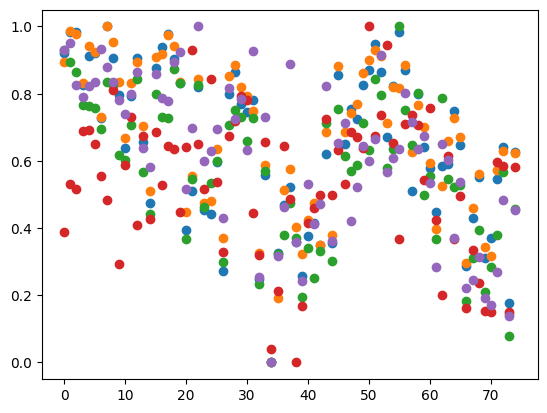

In [12]:
attr = []
mscaledattr = []
nscaledattr = []
for x in range(5):
    attr.append([i[x] for i in mAttList])
    scaledattr = [(i - min(attr[x]))/(max(attr[x]) - min(attr[x])) for i in attr[x]]
    plt.scatter(range(len(dataset)) , scaledattr)
    #plt.scatter(range(len(dataset)) , attr[x])
    print(pd.Series(scaledattr).std())
    mscaledattr.append(scaledattr)
    nscaledattr.append(attr[x])

# testing on sample
# doc = nlp(" ".join(sample.tolist()))
# dlist = attrSep(doc)
# plt.scatter(range(5), dlist)
plt.show()

In [17]:
# script to save all the data, for import and analysis later
import csv
f = open('defdata.csv', 'w')
writer = csv.writer(f)
writer.writerow(['title', 'speaker', 'classification', 'informative', 'persuasive', 'descriptive', 'entertaining', 'ceremonial'])
Tscaledattr = []
for i in range(len(nscaledattr[0])):
    Tscaledattr.append([dataset.loc[i, 'Title'], dataset.loc[i, 'Author'], dataset.loc[i, 'Category']] 
        + [x[i] for x in nscaledattr])
writer.writerows(i for i in Tscaledattr)
f.close()

In [20]:
analyse = pd.read_csv('defdata.csv')


/tmp/ipykernel_10761/637654548.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  analyse.std().tolist()[-5:]


[0.058327362995528244,
 0.057716508824152475,
 0.09150666213267902,
 0.028642469199074486,
 0.05188067126127823]